# Visualize and process the DEM to extract slope and contours

<a name="Author"></a>
## Author
Bishal Dhungana

NextEraEnergy

In [1]:
# Import Modules
import copy
import json
import math
import os
import re
import subprocess
from datetime import datetime

import numpy as np
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import pdal
import pyproj
import requests
import rasterio
import richdem as rd
from osgeo import gdal, ogr, osr
from shapely.geometry import shape, Point, Polygon
from shapely.ops import transform

import xarray as xr
import rioxarray as rxr
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import rasterio.warp

#### Define AOI and Other Input parameters

In [2]:
# Define the EPSG code for the state plane coordinate system
stateplane_epsg = 6475

# Define the path to the shapefile or AOI
shapefile_path = "../shp/Claylick_demo.shp" # /path/to/your/shapefile/shapefile.shp

# Define the input DEM file path
dtm_name = '../tif/test_dtm.tif'  # /path/to/your/dtm/dtm.tif 

# Define the contour intervals as your need
contour_intervals = [1, 5]  # List of intervals in feet

In [3]:
def transform_aoi_to_stateplane(aoi_wkt, target_epsg):
    """
    Transform and project the AOI to the target State Plane coordinate system.

    Parameters:
        aoi_wkt (str): The WKT representation of the AOI.
        target_epsg (int): The EPSG code of the target State Plane coordinate system.

    Returns:
        aoi_wkt_transformed (str): The WKT representation of the transformed AOI.
    """
    # Define the target projection
    target_srs = osr.SpatialReference()
    target_srs.ImportFromEPSG(target_epsg)

    # Create AOI geometry
    aoi_geom = ogr.CreateGeometryFromWkt(aoi_wkt)
    
    # Assign the source SRS if not already assigned
    source_srs = aoi_geom.GetSpatialReference()
    if source_srs is None:
        source_srs = osr.SpatialReference()
        source_srs.ImportFromEPSG(4326)  # Assuming the AOI is in WGS 84 if not specified

    # Check the EPSG code of the AOI
    source_epsg = source_srs.GetAuthorityCode(None)

    if source_epsg == str(target_epsg):
        # AOI is already in the target EPSG, no transformation needed
        return aoi_wkt
    elif source_epsg == '4269':
        # AOI is in NAD 83, project it directly to the target EPSG
        aoi_geom.Transform(osr.CoordinateTransformation(source_srs, target_srs))
    else:
        # AOI is in a different EPSG, transform it to NAD 83 first, then project to the target EPSG
        nad83_srs = osr.SpatialReference()
        nad83_srs.ImportFromEPSG(4269)  # EPSG code for NAD 83
        aoi_geom.Transform(osr.CoordinateTransformation(source_srs, nad83_srs))
        aoi_geom.Transform(osr.CoordinateTransformation(nad83_srs, target_srs))

    return aoi_geom.ExportToWkt()

# Read the AOI WKT from the shapefile
driver = ogr.GetDriverByName('ESRI Shapefile')
dataSource = driver.Open(shapefile_path, 0)  # 0 means read-only. 1 means writeable.
layer = dataSource.GetLayer()
feature = layer.GetNextFeature()
aoi_wkt = feature.GetGeometryRef().ExportToWkt()

# Transform the AOI to the State Plane coordinate system
transformed_aoi_wkt = transform_aoi_to_stateplane(aoi_wkt, stateplane_epsg)
print(transformed_aoi_wkt)

POLYGON ((491427015.936618 -105150959.426031 0,487398096.08983 -104052178.097471 0,486521583.196244 -103881340.683028 0,488109139.185457 -104324306.496764 0,487518848.520402 -104221608.244154 0,489113700.046204 -104675753.385853 0,490439711.284285 -104993737.77992 0,491822889.131515 -105358306.233721 0,490884576.837023 -105036705.082777 0,491427015.936618 -105150959.426031 0))


<a name="Visualize-DEM"></a>
## Visualize the DEM
We can now visualize the DEM products in the Jupyter Notebook. We use the <a href="https://corteva.github.io/rioxarray/stable/"> rioxarray </a> and <a href="https://matplotlib.org/stable/users/index.html"> matplotlib </a> Python libraries for simple plotting. Make sure you have imported `rioxarray` and `matplotlib.pyplot` already.

Now we must define the file name we would like to plot. This could be a file path (e.g., `/path/to/my/dtm/dtm.tif`). Then we open the dtm as an `xarray` object.


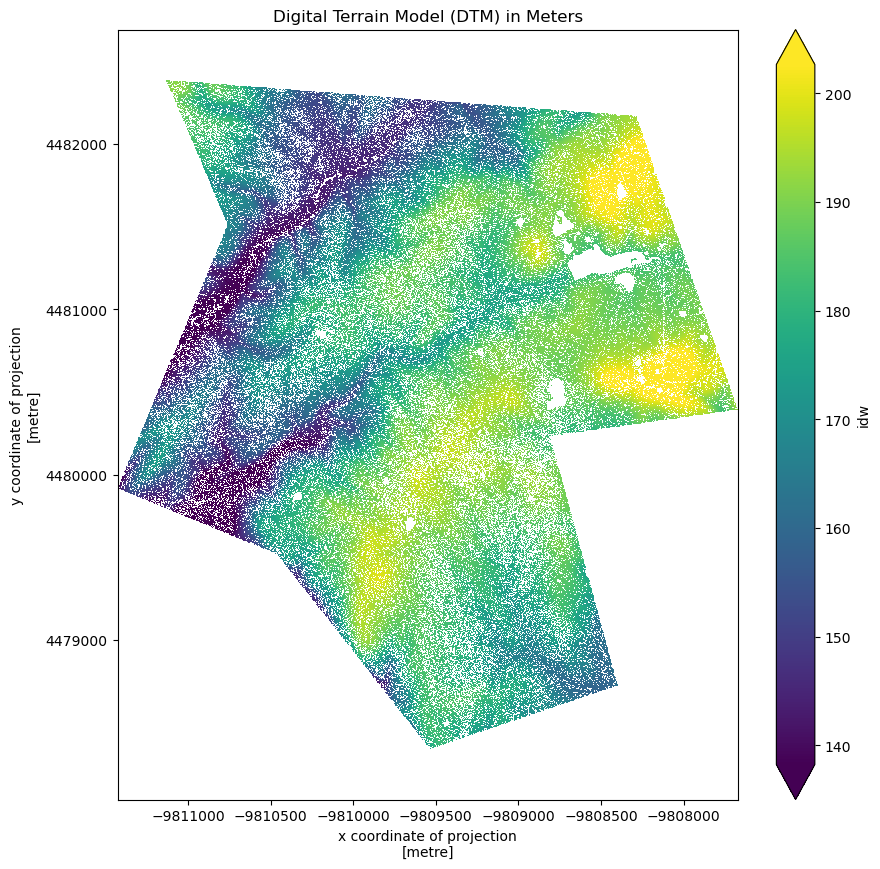

In [4]:
def downsample_dem(dem):
    """
    Function for evaluating whether DEM should be downsampled prior to plotting. If dem.shape is larger than target.shape, the dem is downsampled.

    Parameters:
        dem (array): 2-D numpy array representing the dem data

    Returns: 
        down_sampled (array): Downsampled 2-D numpy array (if dimensions exceed target dimensions)
        OR
        dem (array): Original 2-D numpy array (if downsampling is not needed)
    """
    target_shape = tuple((1000,1000))   # if either dimension is larger than 1000 pixels, the dem will be downsampled
    scale_factors = [dim_target / dim_input for dim_target, dim_input in zip(target_shape, dem.shape)] 
    
    if any(factor < 1 for factor in scale_factors):
        if scale_factors[0] < 1:
            new_width = dem.rio.width * scale_factors[0]
        else:
            new_width = dem.rio.width
        if scale_factors[1] < 1:
            new_height = dem.rio.height * scale_factors[1]
        else:
            new_height = dem.rio.height

        # Downsample DTM/DSM
        down_sampled = dem.rio.reproject(dem.rio.crs, shape=(int(new_height), int(new_width)), resampling=Resampling.bilinear)
        
        return down_sampled
    
    else:
        return dem

# Open the DEM
dtm = rxr.open_rasterio(dtm_name, masked=True).squeeze()

# Downsample the DEM
dtm = downsample_dem(dtm)

# Plot the downsampled DEM
plt.figure(figsize=(10, 10))
dtm.plot(cmap="viridis", robust=True)
plt.title("Digital Terrain Model (DTM) in Meters")
plt.ticklabel_format(style="plain")
plt.axis('equal')
plt.show()

<a name="Fill the voids in DEM"></a>
## Fill the voids in DEM
We can see the voids in dem because of lack of sufficient point cloud data for our dem resolution requirements. We can fill these voids using interpolation techniques. Filling dem is optional because we can create the other products without doing the extra filling.

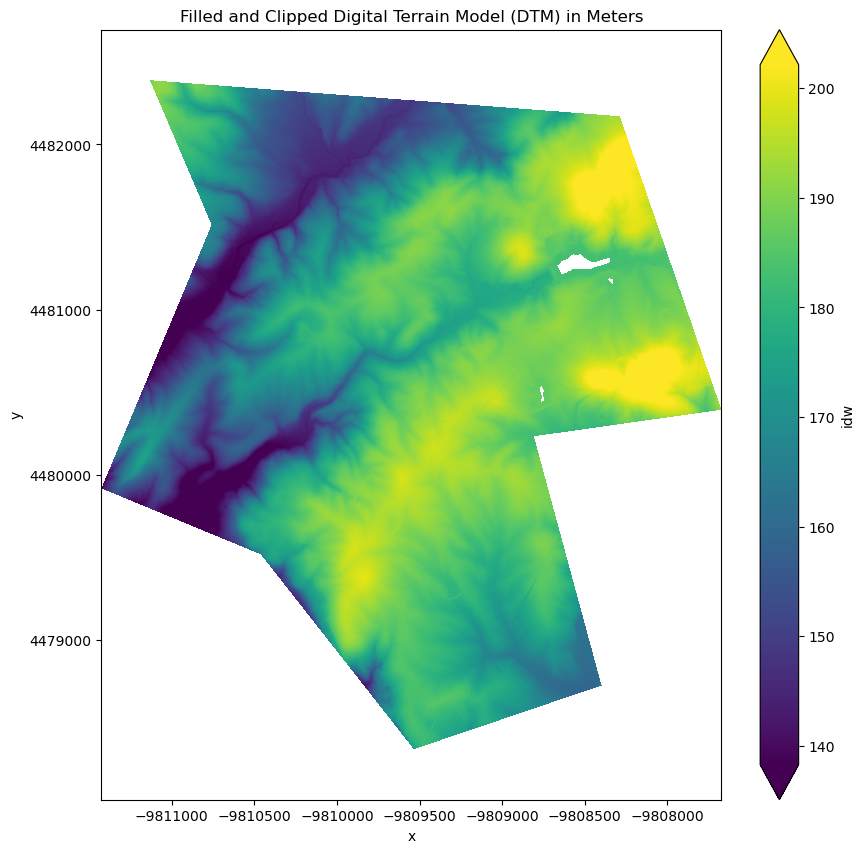

In [5]:
def fill_voids_and_clip_with_gdal(dtm_name, shapefile_path, output_path):
    """
    Function to fill voids in DEM using GDAL and clip it to the AOI.

    Parameters:
        dtm_name (str): The file path of the input DEM.
        shapefile_path (str): The file path of the shapefile defining the AOI.
        output_path (str): The file path of the output filled and clipped DEM.

    Returns:
        filled_dtm (xarray.DataArray): The DEM with voids filled and clipped to the AOI.
    """
    # Open the input DEM in update mode
    src_ds = gdal.Open(dtm_name, gdal.GA_Update)
    src_band = src_ds.GetRasterBand(1)

    # Fill the voids using GDAL's FillNodata function
    gdal.FillNodata(targetBand=src_band, maskBand=None, maxSearchDist=100, smoothingIterations=0)

    # Clip the filled DEM to the AOI
    gdal.Warp(output_path, src_ds, cutlineDSName=shapefile_path, cropToCutline=True, dstNodata=np.nan)

    # Convert the filled and clipped DEM to xarray.DataArray
    filled_dtm = rxr.open_rasterio(output_path, masked=True).squeeze()

    return filled_dtm

# Define the output file path
output_filled_dtm_path = '../tif/filled_dtm.tif'

# Fill the voids in the DEM and clip it to the AOI
filled_dtm = fill_voids_and_clip_with_gdal(dtm_name, shapefile_path, output_filled_dtm_path)

# Plot the filled and clipped DEM
plt.figure(figsize=(10, 10))
filled_dtm.plot(cmap="viridis", robust=True)
plt.title("Filled and Clipped Digital Terrain Model (DTM) in Meters")
plt.ticklabel_format(style="plain")
plt.axis('equal')
plt.show()


<a name="Reproject DEM to stateplane cordinate system"></a>
## Reproject DEM to stateplane cordinate system

For making the mapbooks, we use the stateplane cordinate system. For publishing the products as esri services, we don't have to do the transformation and projection.

In [6]:
# def reproject_raster_to_stateplane(input_raster, target_epsg, output_raster, aoi_wkt):
#     """
#     Reproject a raster to the target State Plane coordinate system and clip it to the AOI.

#     Parameters:
#         input_raster (str): The file path of the input raster.
#         target_epsg (int): The EPSG code of the target State Plane coordinate system.
#         output_raster (str): The file path of the output raster.
#         aoi_wkt (str): The WKT representation of the AOI.
#     """
#     # Open the input raster
#     src_ds = gdal.Open(input_raster, gdal.GA_Update)
#     src_srs = osr.SpatialReference()
#     src_srs.ImportFromWkt(src_ds.GetProjection())

#     # Apply vertical scaling factor to convert meters to feet (1 meter = 3.28084 feet)
#     band = src_ds.GetRasterBand(1)
#     array = band.ReadAsArray()
#     array = array * 3.28084
#     band.WriteArray(array)
#     src_ds = None

#     # Save the scaled raster as an intermediate file
#     intermediate_raster = '../tif/intermediate_scaled.tif'
#     gdal.Translate(intermediate_raster, input_raster)

#     # Define the target projection
#     target_srs = osr.SpatialReference()
#     target_srs.ImportFromEPSG(target_epsg)

#     # Check the EPSG code of the raster
#     source_epsg = src_srs.GetAuthorityCode(None)

#     if source_epsg == str(target_epsg):
#         # Raster is already in the target EPSG, no transformation needed
#         gdal.Warp(output_raster, intermediate_raster, dstSRS=target_srs.ExportToWkt(), format='GTiff', cutlineDSName=None, cutlineWKT=aoi_wkt, cropToCutline=True, dstNodata=np.nan)
#     elif source_epsg == '4269':
#         # Raster is in NAD 83, project it directly to the target EPSG
#         gdal.Warp(output_raster, intermediate_raster, dstSRS=target_srs.ExportToWkt(), format='GTiff', cutlineDSName=None, cutlineWKT=aoi_wkt, cropToCutline=True, dstNodata=np.nan)
#     else:
#         # Raster is in a different EPSG, transform it to NAD 83 first, then project to the target EPSG
#         nad83_srs = osr.SpatialReference()
#         nad83_srs.ImportFromEPSG(4269)  # EPSG code for NAD 83
#         intermediate_raster_nad83 = '../tif/intermediate_scaled_nad83.tif'
#         gdal.Warp(intermediate_raster_nad83, intermediate_raster, dstSRS=nad83_srs.ExportToWkt(), format='GTiff')
#         gdal.Warp(output_raster, intermediate_raster_nad83, dstSRS=target_srs.ExportToWkt(), format='GTiff', cutlineDSName=None, cutlineWKT=aoi_wkt, cropToCutline=True, dstNodata=np.nan)
#         os.remove(intermediate_raster_nad83)

#     os.remove(intermediate_raster)

# # Reproject the raster to the State Plane coordinate system and clip it to the AOI
# reproject_raster_to_stateplane(dtm_name, stateplane_epsg, '../tif/stateplane_dtm.tif', transformed_aoi_wkt)

<a name="Create the products"></a>
## Create the products
Finally we can create the products. We will create a hillshade, slope, and contours from the filled DEM in the State Plane coordinate system.

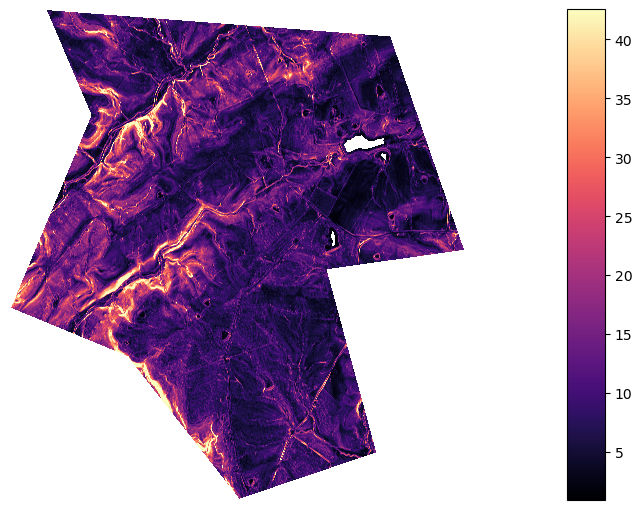

In [7]:
def calculate_and_save_slope(dem_path, output_slope_path, cell_size=10):
    """
    Calculate the slope from a DEM using RichDEM, resample to the specified cell size, and save it as a TIFF file.

    Parameters:
        dem_path (str): The file path of the input DEM.
        output_slope_path (str): The file path to save the output slope raster.
        cell_size (int): The desired cell size for the output slope raster in feet.

    Returns:
        slope_resampled (numpy.ndarray): The resampled slope array.
    """
    # Load the DEM using RichDEM
    dem = rd.LoadGDAL(dem_path)
    
    # Calculate the slope
    slope = rd.TerrainAttribute(dem, attrib='slope_percentage')
    
    # Resample the slope to the specified cell size
    with rasterio.open(dem_path) as src:
        transform = src.transform
        new_transform = rasterio.Affine(cell_size, transform.b, transform.c, transform.d, -cell_size, transform.f)
        new_width = int((src.bounds.right - src.bounds.left) / cell_size)
        new_height = int((src.bounds.top - src.bounds.bottom) / cell_size)
        
        slope_resampled = np.empty((new_height, new_width), dtype=np.float32)
        
        rasterio.warp.reproject(
            source=slope,
            destination=slope_resampled,
            src_transform=transform,
            src_crs=src.crs,
            dst_transform=new_transform,
            dst_crs=src.crs,
            resampling=Resampling.bilinear
        )
        
        # Save the resampled slope as a TIFF file
        profile = src.profile
        profile.update({
            'dtype': 'float32',
            'height': new_height,
            'width': new_width,
            'transform': new_transform
        })
        
        with rasterio.open(output_slope_path, 'w', **profile) as dst:
            dst.write(slope_resampled, 1)
    
    return slope_resampled

# Calculate the slope, resample it, and save it as a TIFF file
slope_resampled = calculate_and_save_slope(output_filled_dtm_path, '../tif/slope_map.tif')

# # Plot the slope
dem = rd.LoadGDAL(output_filled_dtm_path)
slope = rd.TerrainAttribute(dem, attrib='slope_percentage')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

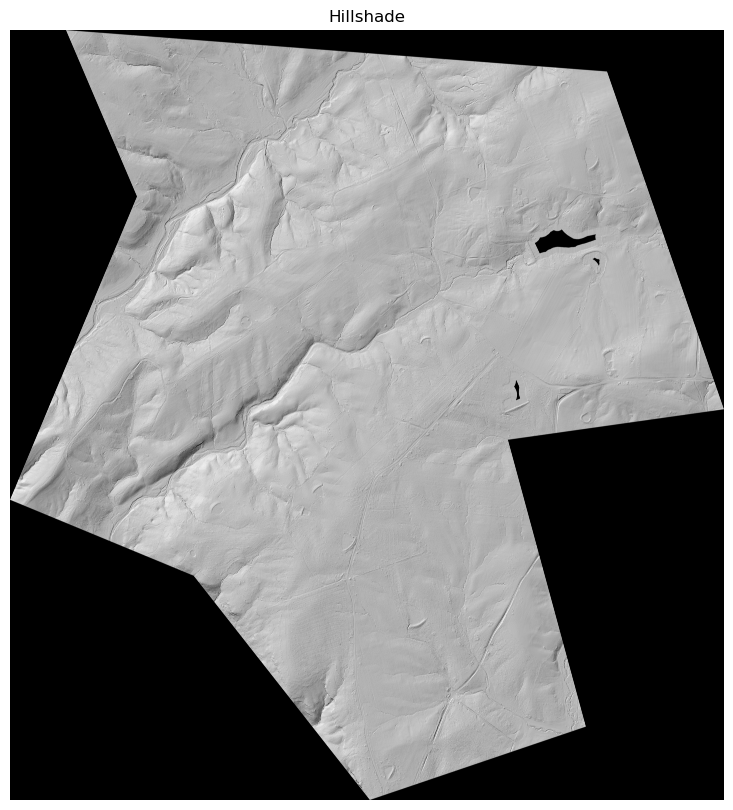

In [10]:
def calculate_and_save_hillshade(dem_path, output_hillshade_path, azimuth=315, altitude=45, z_factor=1):
    """
    Calculate the hillshade from a DEM using GDAL and save it as a TIFF file.

    Parameters:
        dem_path (str): The file path of the input DEM.
        output_hillshade_path (str): The file path to save the output hillshade raster.
        azimuth (int): The azimuth angle of the light source.
        altitude (int): The altitude angle of the light source.
        z_factor (float): The vertical exaggeration factor.

    Returns:
        hillshade (numpy.ndarray): The hillshade array.
    """
    # Open the DEM
    dem_ds = gdal.Open(dem_path)
    
    # Calculate the hillshade
    hillshade_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', azimuth=azimuth, altitude=altitude, zFactor=z_factor, format='MEM')
    
    # Read the hillshade data
    hillshade = hillshade_ds.GetRasterBand(1).ReadAsArray()
    
    # Save the hillshade as a TIFF file
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.CreateCopy(output_hillshade_path, hillshade_ds)
    out_ds = None  # Close the file
    
    return hillshade

# Calculate the hillshade and save it as a TIFF file
hillshade = calculate_and_save_hillshade(output_filled_dtm_path, '../tif/hillshade_map.tif')

# Plot the hillshade
plt.figure(figsize=(10, 10))
plt.imshow(hillshade, cmap='gray')
plt.title("Hillshade")
plt.axis('off')
plt.show()


In [8]:
def create_contours(input_raster, output_directory, intervals):
    """
    Create contour shapefiles from a DEM for multiple intervals.

    Parameters:
        input_raster (str): The file path of the input DEM.
        output_directory (str): The directory to save the output shapefiles.
        intervals (list): A list of contour intervals in feet.

    Returns:
        None
    """
    # Open the input raster
    src_ds = gdal.Open(input_raster)
    src_band = src_ds.GetRasterBand(1)
    
    # Convert the elevation values from meters to feet
    elevation_array = src_band.ReadAsArray()
    elevation_array = elevation_array * 3.28084  # 1 meter = 3.28084 feet
    
    # Create an in-memory raster with the converted elevation values
    driver = gdal.GetDriverByName('MEM')
    mem_ds = driver.Create('', src_ds.RasterXSize, src_ds.RasterYSize, 1, gdal.GDT_Float32)
    mem_ds.SetGeoTransform(src_ds.GetGeoTransform())
    mem_ds.SetProjection(src_ds.GetProjection())
    mem_band = mem_ds.GetRasterBand(1)
    mem_band.WriteArray(elevation_array)
    
    # Create the output shapefile driver
    driver = ogr.GetDriverByName('ESRI Shapefile')
    if driver is None:
        raise RuntimeError("ESRI Shapefile driver is not available.")
    
    for interval in intervals:
        # Determine the output shapefile name based on the interval
        output_contour_shapefile = os.path.join(output_directory, f'Contours_{interval}ft.shp')
        
        # Create the output shapefile
        ds = driver.CreateDataSource(output_contour_shapefile)
        if ds is None:
            raise RuntimeError(f"Could not create shapefile: {output_contour_shapefile}")
        
        srs = osr.SpatialReference()
        srs.ImportFromWkt(src_ds.GetProjection())
        layer = ds.CreateLayer('contour', srs, ogr.wkbLineString)
        
        # Add fields
        field_defn = ogr.FieldDefn('ID', ogr.OFTInteger)
        layer.CreateField(field_defn)
        field_defn = ogr.FieldDefn('ELEV', ogr.OFTReal)
        layer.CreateField(field_defn)
        
        # Generate contours
        gdal.ContourGenerate(mem_band, interval, 0, [], 0, 0, layer, 0, 1)
        
        # Close the dataset
        ds = None

    # Close the source dataset
    src_ds = None
    mem_ds = None

output_directory = '../shp' # /path/to/your/output/directory

# Create contours for the specified intervals
create_contours(output_filled_dtm_path, output_directory, contour_intervals)